In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from numpy import linalg as LA

import sys
sys.path.append("..")

from utils import *
from template import *
from vis import *

import ipdb

In [21]:
class Dictionary():
    def __init__(self, batch_size=(6, 6), dtype=1, upscale=2):
        self.upscale = upscale
        self.batch_size = batch_size
        print(dtype)
        # AHF functions
        if dtype == 1: self.dic1()
        self.size = len(self.L['params'])
        

    def dic1(self):
        ths = 2 * np.pi * np.arange(12) / 12
        bs = np.linspace(-6, 6, 13)
        self.L = generate_dic_AHF(ths, bs, [1e-4], (6,6), comb=True)
        self.H = upscale_dic(self.L, batch_size=self.batch_size, upscale=self.upscale)
    
    def dic2(self):
        ths = 2 * np.pi * np.arange(12) / 12
        bs = np.linspace(-6, 6, 13)
        self.L = generate_dic_AHF(ths, bs, [1.0, 1e-4], (6,6), comb=True)
        self.H = upscale_dic(self.L, batch_size=self.batch_size, upscale=self.upscale)
        
        
ahf_dic = Dictionary()

1


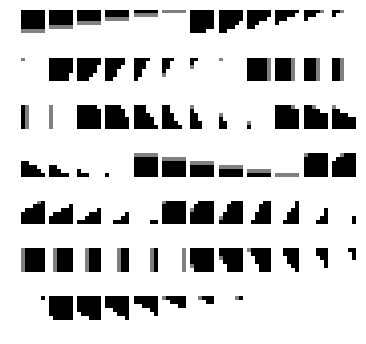

(80, 36)


In [23]:
vis_batches(ahf_dic.L['data'])
print(ahf_dic.L['data'].shape)
# vis_batches(ahf_dic.H['data'], size=(12, 12))

In [19]:
class ImageMFSR():
    def __init__(self, img, batch_size=(6,6), upscale=2, beta=1):
        self.img_L = img
        if np.max(img>1): self.img_L = img / 255.0
        
        self.batch_size = batch_size
        self.upscale = upscale
        self.beta = 1
        
        
        self.dic = Dictionary(upscale=2)
        self.get_batches()

        
        


    def get_batches(self):
        self.patches = []
        W, H = self.img_L.shape
        w, h = self.batch_size
        dw = int(w - w/3)
        dh = int(h - h/3)
        
        # print(W, H)
        
        for i in range(0, W - w, dw):
            for j in range(0, H - h, dh):
                tmp = {}
                tmp['data'] = self.img_L[i:i+w, j:j+h]
                tmp['coordinate'] = (i, j)
                tmp['rep'] = np.zeros(self.dic.size)
                self.patches.append(tmp)
    
    def super_resolution(self):
        W, H = self.img_L.shape # (W, H) is the size of image
        W_, H_ = W*self.upscale, H*self.upscale # (W_, H_) is the size of recovered HR image
        w, h = self.batch_size # (w, h) is the size of the batch
        w_, h_ = w*self.upscale, h*self.upscale
        
        img_H = np.zeros((W_, H_))
        num_patches = len(self.patches)
        
        # set the lasso optimizer
        alpha_ = 0.0001
        from sklearn import linear_model
        clf = linear_model.Lasso(alpha=alpha_, max_iter=100, fit_intercept=False)
        
        count = 0
        
        print(W_, H_)
        
        for patch in self.patches:
            # ipdb.set_trace()
            leftop_x, leftop_y = patch['coordinate']
            
            #===========================================================
            #  prepare the mask
            roi_L = self.img_L[leftop_x:leftop_x + w, leftop_y:leftop_y + h]
            roi_H = img_H[leftop_x * self.upscale : leftop_x * self.upscale + w_, 
                          leftop_y * self.upscale : leftop_y * self.upscale + h_]
            
            # print(roi_H.shape, patch['coordinate'])
            # building mask to dealing with overlap
            mask = np.ones((w_, h_)) * self.beta
            
            # there are four mask type
            if patch['coordinate'][0] == 0 and patch['coordinate'][1] == 0:
                mask[0:w_, 0:h_] = 0
            elif patch['coordinate'][0] == 0:
                mask[0:w_, int(h_/3):h_] = 0
            elif patch['coordinate'][1] == 0:
                mask[int(w_/3):w_, 0:h_] = 0
            else:
                mask[int(w_/3):w_, int(h_/3):h_] = 0
            
            v_mask = mask.reshape(-1, 1)
            
            #===========================================================
            # ||D alpha  -  y ||^2 + ||alpha||^1   
            #  Using LASSO get alpha
            D1 = self.dic.L['data'].transpose()
            D2 = v_mask * self.dic.H['data'].transpose()
            D = np.concatenate((D1, D2))
            
            y1 = roi_L.reshape(-1, 1)
            y2 = v_mask * roi_H.reshape(-1, 1)
            y = np.concatenate((y1, y2))
            
            clf.fit(D, y)
            alpha = np.array(clf.coef_).reshape(-1, 1)
            
            
            #===========================================================
            #  put recovered image to the HR image
            roi_L_SR = np.dot(D1, alpha).reshape(w,h)
            roi_H_SR = np.dot(self.dic.H['data'].transpose(), alpha).reshape(w_, h_)
            
            img_H[leftop_x * self.upscale : leftop_x * self.upscale + w_, 
                  leftop_y * self.upscale : leftop_y * self.upscale + h_] = roi_H_SR
            
            #===========================================================
            #  print the loss
            count += 1
            loss = LA.norm(y - np.dot(D, alpha), 2) + alpha_ * LA.norm(alpha, 1)
            if count % 100 == 0:
                print("patch count: ", count, "    loss: ", loss)
            
            # assert False
            
            
        self.img_H = img_H
        
        
        
        
                
img_L = imgcut(numpy_from_img_route(img_route()))
print(img_L.shape)
img_rep = ImageMFSR(img_L)
img_rep.super_resolution()

/root/Dataset/Set14/image_SRF_2/img_001_SRF_2_LR.png
240 250
238 250
(238, 250)
1
1
476 500
patch count:  100     loss:  0.20853152686376036
patch count:  200     loss:  0.3467025759459203
patch count:  300     loss:  0.4162738594475948
patch count:  400     loss:  0.4383087063957366
patch count:  500     loss:  0.48798875712904055
patch count:  600     loss:  0.467273565531224
patch count:  700     loss:  0.2783699061829937
patch count:  800     loss:  0.5277640343195216
patch count:  900     loss:  0.2374806574565006
patch count:  1000     loss:  0.26723261566256823
patch count:  1100     loss:  0.42283019893430923
patch count:  1200     loss:  0.2750646736951389
patch count:  1300     loss:  0.35308310776708296
patch count:  1400     loss:  0.4444745721407502
patch count:  1500     loss:  0.22928489362693408
patch count:  1600     loss:  0.2465750188726223
patch count:  1700     loss:  0.3271772344349486
patch count:  1800     loss:  0.28169242710987835
patch count:  1900     loss: 

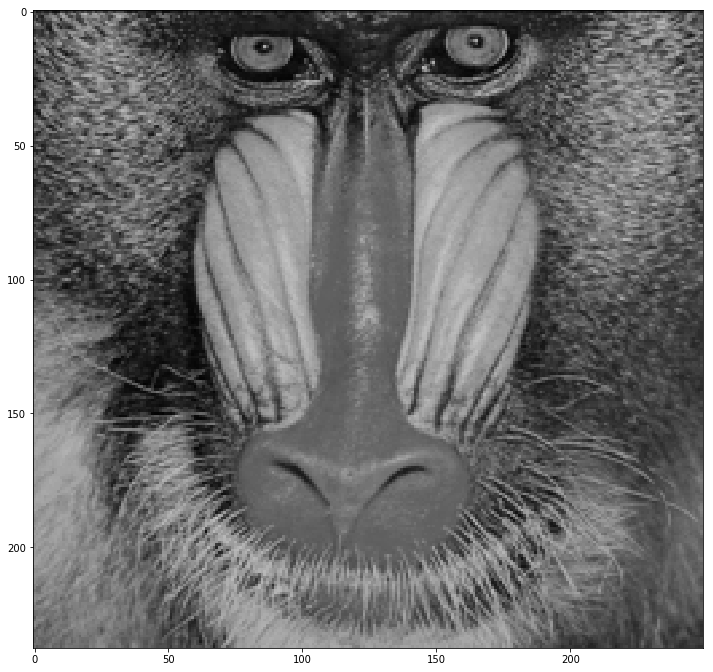

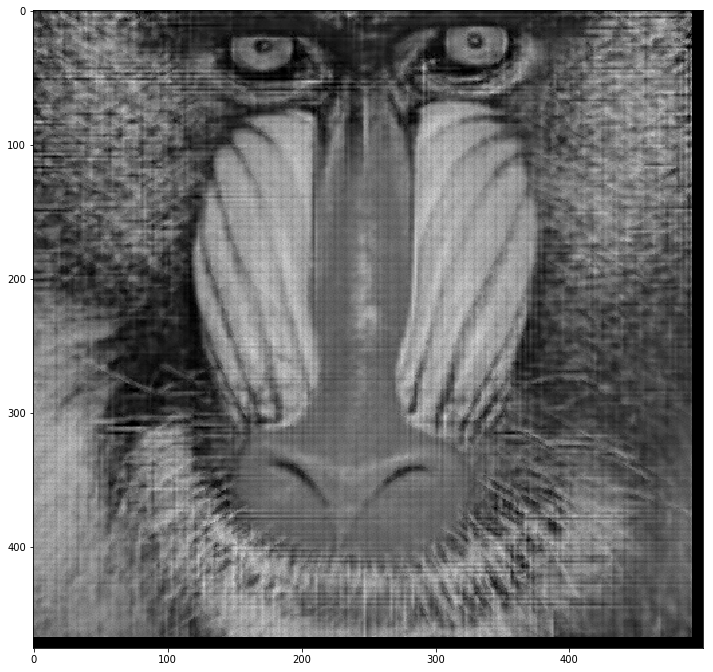

In [20]:
vis_img(img_rep.img_L)
vis_img(img_rep.img_H)

In [14]:
mask = np.zeros((4,4))
mask[0:2, 0:2] = 1
roi = np.random.randn(16,3)

print(roi * mask.reshape(16, -1))
roi = roi * mask.reshape(16, -1)
print(roi[:, 1].reshape(4, 4))

[[ 0.86601486 -0.62904568  0.40118682]
 [-0.21669018 -1.22132605 -1.25779888]
 [ 0.         -0.         -0.        ]
 [ 0.          0.         -0.        ]
 [-0.43505881  0.23165276 -0.79787407]
 [ 1.45589179  0.97077233  2.29740505]
 [-0.          0.         -0.        ]
 [ 0.         -0.          0.        ]
 [ 0.          0.         -0.        ]
 [ 0.          0.         -0.        ]
 [ 0.          0.          0.        ]
 [ 0.         -0.         -0.        ]
 [ 0.          0.          0.        ]
 [-0.          0.          0.        ]
 [-0.         -0.         -0.        ]
 [ 0.          0.         -0.        ]]
[[-0.62904568 -1.22132605 -0.          0.        ]
 [ 0.23165276  0.97077233  0.         -0.        ]
 [ 0.          0.          0.         -0.        ]
 [ 0.          0.         -0.          0.        ]]


/home/e/Eulring/OtherProj/AMFR/img/Set14/image_SRF_2/img_001_SRF_2_LR.png


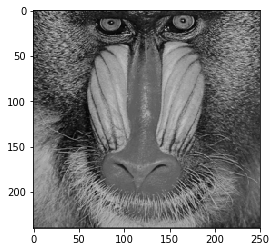

In [11]:
batch_size = (6, 6)

img_L = numpy_from_img_route(img_route())
img_H = numpy_from_img_route(img_route(method = 'HR'))
print(img_route())
vis_img(img_L, v_max = 255)

In [ ]:



def get_batches(img, batch_size = (6, 6)):
    img = 
    


